In [1]:
import matplotlib.pyplot as plt
import src.util_fns as util_fns
import pickle
import numpy as np
import cv2
import os
from pathlib import Path
import xml.etree.ElementTree as ET

In [2]:
metadata = pickle.load(open('./data/metadata.pkl', 'rb'))

raw_data_path = '/userdata/kerasData/data/new_data/raw_images/'
raw_labels_path = '/userdata/kerasData/data/new_data/drive_clone/'
labels_path = '/root/pytorch_lightning_data/drive_clone_numpy/'

example = labels_path+'20180504_FIRE_smer-tcs8-mobo-c/xml/1525469995_+00360.xml'

# Hard Example Mining

In [3]:
def create_hem_list(image_preds_path, output_path):
    """Description: Creates txt file of hardest positive and negative examples sorted by image_loss"""
    
    csv = np.loadtxt(image_preds_path, delimiter=',', dtype=str)

    positive_images = {}
    negative_images = {}

    for image, pred, loss in csv:
        if util_fns.get_ground_truth_label(image) == 1:
            positive_images[image] = float(loss)
        else:
            negative_images[image] = float(loss)

    num_to_keep = (len(positive_images)+len(negative_images))//10

    hem_list = sorted(negative_images, key=negative_images.get)[-num_to_keep:] + sorted(positive_images, key=positive_images.get)[-num_to_keep:]

    np.savetxt(output_path, hem_list, fmt='%s')
    

In [4]:
image_preds_path = './saved_logs_195-209/1MobileNet_LSTM_SpatialViT_90Resize_DataAugment_ImagePreds_HEM-Test/version_0/image_preds.csv'
output_path = './data/split1/hem-train_images1.txt'

create_hem_list(image_preds_path, output_path)

# Helper Functions

In [3]:
resize_dimensions = (1392, 1856)
crop_height = 1040
tile_dimensions = (224, 224)
tile_overlap = 20
num_tiles_height, num_tiles_width = util_fns.calculate_num_tiles(resize_dimensions, crop_height, tile_dimensions, tile_overlap)

In [4]:
def calculate_overlap_ticks(max_dim, tile_size=224, tile_overlap=20):
    i = 0
    dim = 0
    ticks = []

    while dim < max_dim:
        if i == 0:
            dim += tile_size-tile_overlap
        elif i % 2 == 1:
            dim += tile_overlap
        elif i % 2 == 0:
            dim += tile_size-tile_overlap*2

        ticks.append(dim)
        i += 1
    
    return ticks

In [5]:
def display_image(image_name, image_pred=None, tile_preds=None, tile_probs=None, idx=0, save_path=None):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image_path = raw_data_path+image_name+'.jpg'
    label_image_path = raw_labels_path+util_fns.get_fire_name(image_name)+'/labels/'+util_fns.get_only_image_name(image_name)+'.jpg'
    
    if Path(label_image_path).exists():
        filename = label_image_path
    elif Path(image_path).exists():
        filename = image_path
    else:
        print('No image to display.')
        return
    
    # Load and process image
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (825, 620))
    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    
    # Display image
    plt.figure(figsize=(16, 12), dpi=80)
    plt.title(str(idx)+'. '+filename)
    plt.imshow(img)
    
    # Calculate grid ticks
    plt.xticks(calculate_overlap_ticks(resize_dimensions[1], tile_dimensions[1], tile_overlap))
    plt.yticks(calculate_overlap_ticks(crop_height, tile_dimensions[0], tile_overlap))
    plt.grid()
    
    # Insert tile preds text
    if tile_preds is not None or tile_probs is not None:
        x_text_ticks = np.insert(np.arange(tile_dimensions[1],resize_dimensions[1],tile_dimensions[1]-tile_overlap), 0, 0)
        y_text_ticks = np.insert(np.arange(tile_dimensions[0],crop_height,tile_dimensions[0]-tile_overlap), 0, 0)+tile_overlap

        for i, x in enumerate(x_text_ticks):
            for j, y in enumerate(y_text_ticks):
                if tile_preds is not None:
                    plt.text(x,y, tile_preds[j,i], size='medium', weight='heavy', color='white' if tile_preds[j,i]==0 else 'red')
                else:
                    plt.text(x,y, round(tile_probs[j,i], 2), size='medium', weight='heavy', color='white' if tile_probs[j,i]<0.5 else 'red')
                    
    # Insert image preds text
    if image_pred is not None:
        plt.text(resize_dimensions[1]-200,crop_height-20, 'image_pred='+str(image_pred), size='medium', weight='heavy', color='white' if image_pred==0 else 'red')
        
    if save_path is not None:
        plt.savefig(save_path)
        plt.close()

In [6]:
def display_raw_labels(filename):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    
    plt.figure(figsize=(16, 12), dpi=80)
    plt.title(filename)
    plt.imshow(img)

# Visualize Errors

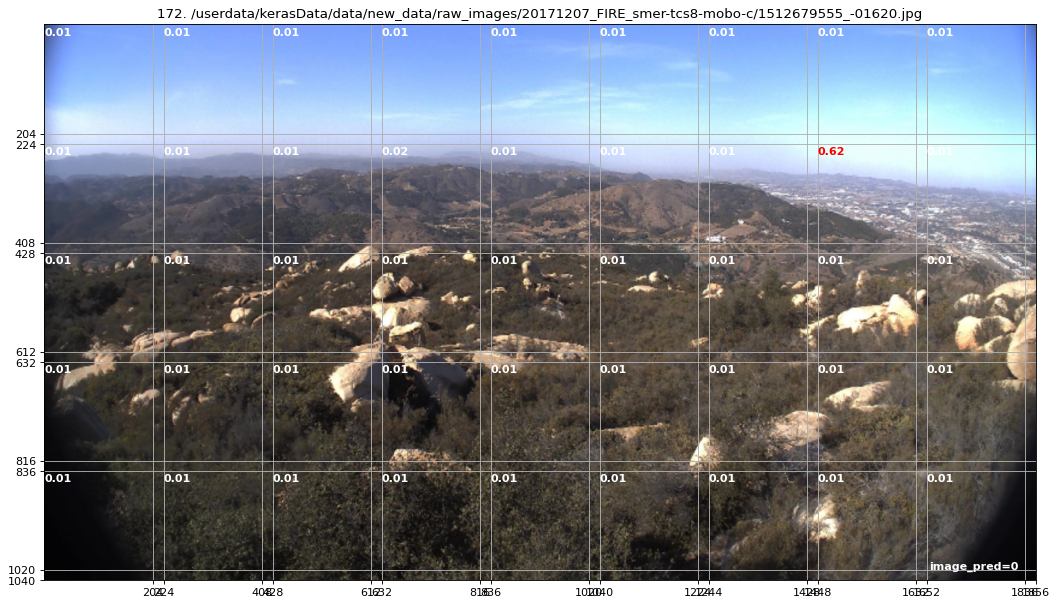

In [52]:
save_path = None

# EDIT: path to results
results_path = '/userdata/kerasData/src/pytorch-lightning-smoke-detection/saved_logs/version_227/'

# EDIT: If fig should be saved
# save_path = './saved_figs/MobileNet_LSTM_DeiT_LinearOutputs/false_negatives/'
# os.makedirs(save_path, exist_ok=True)

image_preds = np.loadtxt(results_path+'image_preds.csv', delimiter=',', dtype=str)
for j, (image, image_pred, loss) in enumerate(image_preds):
    # EDIT: Change j < <value> to search for next error
    if j < 50 and save_path is None: continue
    
    
    ### Errors Only ###
#     if int(image_pred) == util_fns.get_ground_truth_label(image): continue
    ### False Positives Only ###
#     if int(image_pred) != 1 or util_fns.get_ground_truth_label(image) != 0: continue
    ### False Negatives Only ###
#     if int(image_pred) != 0 or util_fns.get_ground_truth_label(image) != 1: continue
    ### Correct Only ###
    if int(image_pred) != util_fns.get_ground_truth_label(image): continue
    ### True Positives Only ###
#     if int(image_pred) != 1 or util_fns.get_ground_truth_label(image) != 1: continue
    ### True Negatives Only ###
#     if int(image_pred) != 0 or util_fns.get_ground_truth_label(image) != 0: continue
        
    # Save path variables
    tile_probs_path = results_path+'tile_probs/'+image+'.npy'
    tile_preds_path = results_path+'tile_preds/'+image+'.npy'
    save_path_j = save_path+str(j) if save_path is not None else None
    
    ### Tile Prediction != Image Prediction ###
#      preds = np.load(tile_preds_path).reshape((num_tiles_height,num_tiles_width))
#     if (preds.sum() > 0 and int(image_pred) == 1) or (preds.sum() == 0 and int(image_pred) == 0): continue
    
    # Load preds
    probs = np.load(tile_probs_path).reshape((num_tiles_height,num_tiles_width))
    
    # Display image
    display_image(image, int(image_pred), tile_probs=probs, idx=j, save_path=save_path_j)
        
    if save_path is None: break

# Other Stuff

In [148]:
for fire in metadata['fire_to_images']:
    image = metadata['fire_to_images'][fire][0]
    raw_image_path = raw_data_path+image+'.jpg'
    display_tiles(raw_image_path)
    break

NameError: name 'display_tiles' is not defined

In [47]:
for i in range(20):
    print(224*i, 224+(i-1)*204)
    

0 20
224 224
448 428
672 632
896 836
1120 1040
1344 1244
1568 1448
1792 1652
2016 1856
2240 2060
2464 2264
2688 2468
2912 2672
3136 2876
3360 3080
3584 3284
3808 3488
4032 3692
4256 3896


In [42]:
def display_tiles(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    original_img = cv2.imread(filename)
    original_img = cv2.resize(original_img, (2060,1536))[-1244:]
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

#     original_img = original_img.reshape((5, 224, 9, 224, 3)).swapaxes(1,2).reshape((-1,224,224,3))
    
#     original_img = np.transpose(original_img, (2,0,1))
    
    bytelength = original_img.nbytes // original_img.size
    
    original_img = np.lib.stride_tricks.as_strided(
                    original_img, 
                    shape=( 
                           6, 
                           10, 
                           224, 
                           224,3), 
                    strides=(2060*204*bytelength*3,
                             204*bytelength*3, 
                             2060*bytelength*3, 
                             bytelength*3, 
                             bytelength)).reshape((-1, 224, 224, 3))
#     original_img = np.transpose(original_img.reshape((3, -1, 224,224)), (1,2,3,0))


#     original_img = np.lib.stride_tricks.sliding_window_view(original_img, (224,224), axis=(0,1))[::224, ::224]
#     original_img = original_img.reshape(-1, 224, 224, 3)
    
    for tile in original_img:
        plt.figure(figsize=(4, 4), dpi=20)
        plt.imshow(tile)

# Visualize All Images

60. 20180603_FIRE_smer-tcs8-mobo-c/1528058095_+00840


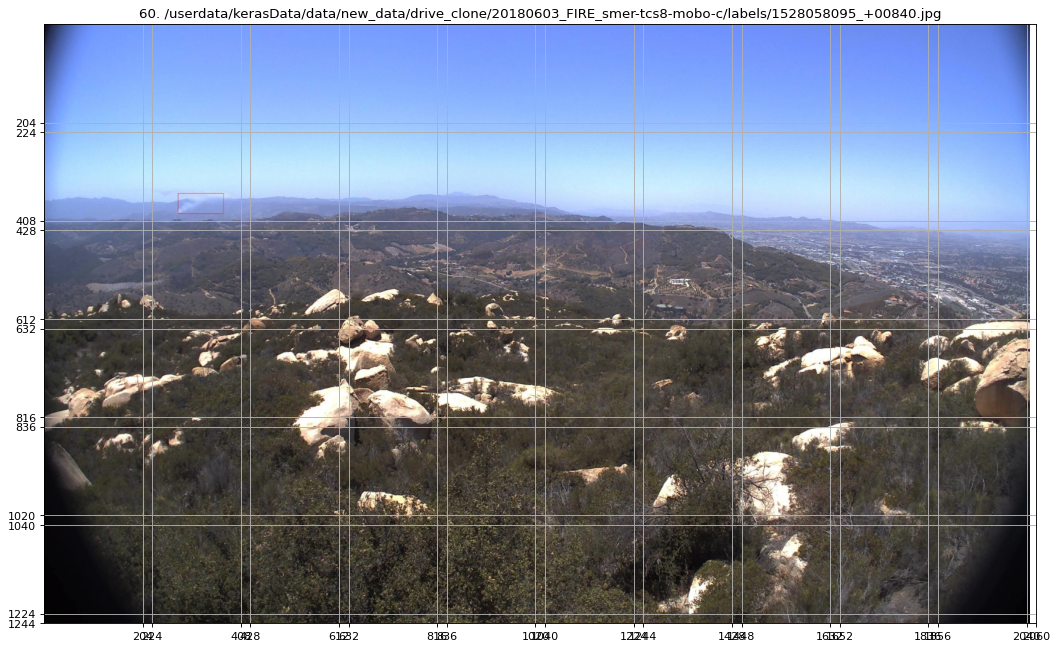

In [7]:
# Original Image
resize_dimensions = (1536, 2048)
crop_height = 1244

for i, image in enumerate(metadata['omit_no_contour']):
    if i < 60 or i >= 61:
        continue
    
    image_path = raw_data_path+image+'.jpg'
    label_image_path = raw_labels_path+util_fns.get_fire_name(image)+'/labels/'+util_fns.get_only_image_name(image)+'.jpg'

    
    # Load image
    print(str(i)+'. '+image)
    if Path(label_image_path).exists():
        display_image(label_image_path, idx=i)
    elif Path(image_path).exists():
        display_image(image_path, idx=i)

60. 20180603_FIRE_smer-tcs8-mobo-c/1528058095_+00840


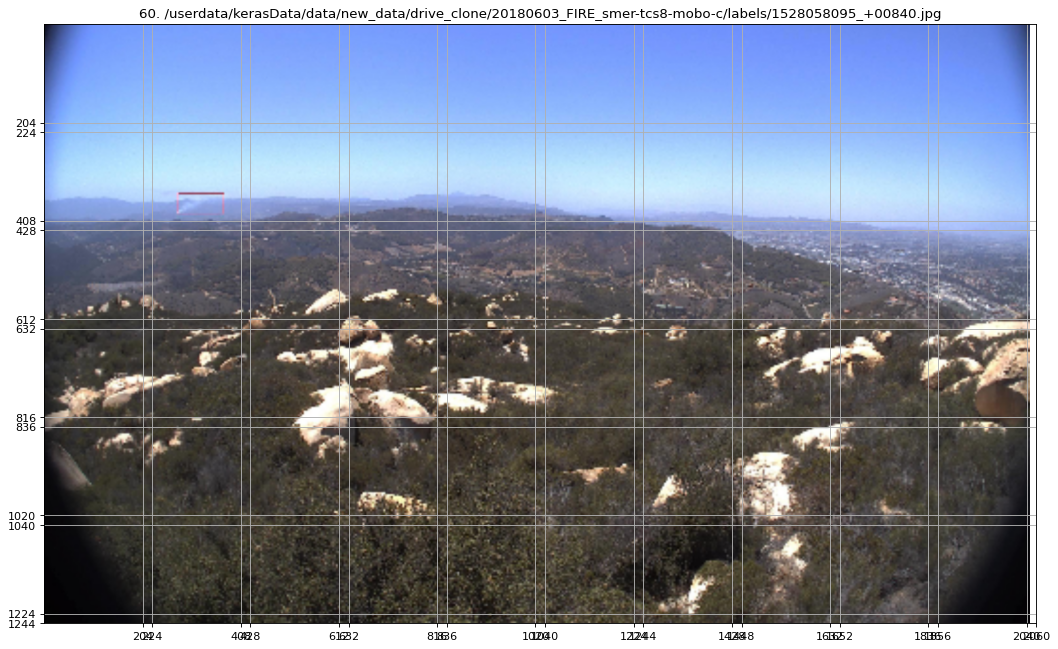

In [13]:
# Downsize and upsize

resize_dimensions = (1536, 2048)
crop_height = 1244

for i, image in enumerate(metadata['omit_no_contour']):
    if i < 60 or i >= 61:
        continue
    
    image_path = raw_data_path+image+'.jpg'
    label_image_path = raw_labels_path+util_fns.get_fire_name(image)+'/labels/'+util_fns.get_only_image_name(image)+'.jpg'

    
    # Load image
    print(str(i)+'. '+image)
    if Path(label_image_path).exists():
        display_image(label_image_path, idx=i)
    elif Path(image_path).exists():
        display_image(image_path, idx=i)